In [15]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np


In [16]:
UNIT = '1'
MARKET = 'KRW-XRP'

data_columns = {
    'market': 'Market',
    'candle_date_time_utc': 'Date',
    'opening_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'trade_price': 'Close',
    'candle_acc_trade_volume': 'Volume',
    'candle_acc_trade_price' : 'Price',
}

# str UTC DATETIME
def get_query_datetime():
    now = datetime.datetime.now() #- datetime.timedelta(hours=9)
    now = str(now.strftime('%Y-%m-%d %H:%M:%S'))
    now = now.replace(' ', 'T') + 'Z'
    return now


# 크롤링한 데이터 전처리
def preprocessing_crawled_data(datas: str):
    array_dict_datas = []
    array_datas = datas.split('},')

    for data in array_datas:
        array_data = []
        data = data.replace('{', '')
        data = data.replace('}', '')
        array_data = data.split(',')

        dict_data = {}
        for value in array_data:
            tmp = value.split(':', 1)
            if tmp[0][1: -1] in data_columns:
                dict_data[data_columns[tmp[0][1: -1]]] = tmp[1]

        dict_data['Market'] = dict_data['Market'][1: -1]
        dict_data['Date'] = dict_data['Date'][1: -1]
        dict_data['Open'] = float(dict_data['Open'])
        dict_data['High'] = float(dict_data['High'])
        dict_data['Low'] = float(dict_data['Low'])
        dict_data['Close'] = float(dict_data['Close'])
        dict_data['Volume'] = float(dict_data['Volume'])
        dict_data['Price'] = float(dict_data['Price'])
        array_dict_datas.append(dict_data)

    return array_dict_datas


# 크롤링 후 df 리턴
def do_crawl(unit: str, market: str, time: str, count: str, loop: int):
    df = pd.DataFrame([], columns=['Date', 'Market', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price'])
    url = "https://api.upbit.com/v1/candles/minutes/" + unit

    for _ in range(loop):
        querystring = {"market": market, "to": time, "count": count}
        response = requests.request("GET", url, params=querystring)
        df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
        time = df.iloc[-1]['Date'] + 'Z'
    df = df.loc[::-1].reset_index(drop=True)
    return df




# first 데이터 셋 만들기
df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 50)
df.to_csv("test.csv")

print(df)

                     Date   Market   Open   High    Low  Close         Volume  \
0     2023-05-23T16:02:00  KRW-XRP  617.0  617.0  616.0  616.0   11770.056330   
1     2023-05-23T16:03:00  KRW-XRP  616.0  617.0  616.0  616.0   10456.523417   
2     2023-05-23T16:04:00  KRW-XRP  616.0  617.0  616.0  617.0    7523.221917   
3     2023-05-23T16:05:00  KRW-XRP  616.0  617.0  616.0  617.0    4833.469290   
4     2023-05-23T16:06:00  KRW-XRP  617.0  617.0  616.0  617.0    8914.811796   
...                   ...      ...    ...    ...    ...    ...            ...   
9995  2023-05-30T14:56:00  KRW-XRP  665.0  666.0  664.0  666.0  205338.324111   
9996  2023-05-30T14:57:00  KRW-XRP  666.0  666.0  665.0  666.0   50200.334726   
9997  2023-05-30T14:58:00  KRW-XRP  665.0  666.0  664.0  664.0   78896.558408   
9998  2023-05-30T14:59:00  KRW-XRP  664.0  665.0  663.0  663.0  152684.214570   
9999  2023-05-30T15:00:00  KRW-XRP  664.0  664.0  663.0  663.0    7263.155045   

             Price  
0     

Text(0, 0.5, 'price')

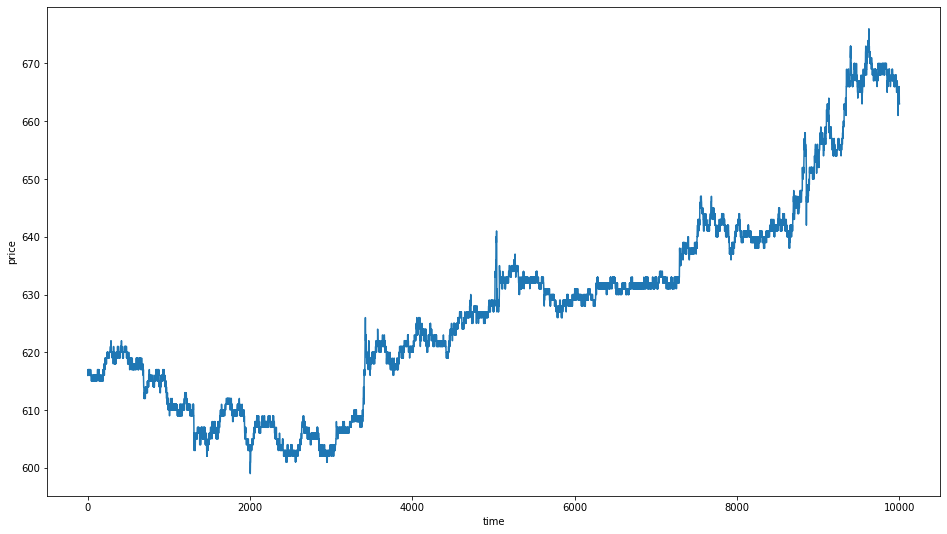

In [17]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [18]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

          Open      High       Low     Close    Volume     Price
0     0.236842  0.223684  0.226667  0.220779  0.001737  0.001699
1     0.223684  0.223684  0.226667  0.220779  0.001543  0.001509
2     0.223684  0.223684  0.226667  0.233766  0.001110  0.001086
3     0.223684  0.223684  0.226667  0.233766  0.000713  0.000697
4     0.236842  0.223684  0.226667  0.233766  0.001316  0.001287
...        ...       ...       ...       ...       ...       ...
9995  0.868421  0.868421  0.866667  0.870130  0.030329  0.032016
9996  0.881579  0.868421  0.880000  0.870130  0.007414  0.007832
9997  0.868421  0.868421  0.866667  0.844156  0.011653  0.012293
9998  0.855263  0.855263  0.853333  0.831169  0.022552  0.023768
9999  0.855263  0.842105  0.853333  0.831169  0.001072  0.001129

[10000 rows x 6 columns]


In [19]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)
x_train.shape, y_train.shape
print(type(x_test))
print(x_test)

<class 'pandas.core.frame.DataFrame'>
          Open      High       Low    Volume     Price
9000  0.723684  0.710526  0.720000  0.013406  0.013913
9001  0.723684  0.710526  0.720000  0.006860  0.007115
9002  0.710526  0.710526  0.706667  0.037897  0.039251
9003  0.697368  0.697368  0.706667  0.023694  0.024536
9004  0.697368  0.697368  0.706667  0.021707  0.022475
...        ...       ...       ...       ...       ...
9995  0.868421  0.868421  0.866667  0.030329  0.032016
9996  0.881579  0.868421  0.880000  0.007414  0.007832
9997  0.868421  0.868421  0.866667  0.011653  0.012293
9998  0.855263  0.855263  0.853333  0.022552  0.023768
9999  0.855263  0.842105  0.853333  0.001072  0.001129

[1000 rows x 5 columns]


In [20]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [21]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [28]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yoojunho/anaconda3/envs/python_3/lib/python3.6/site-packages/tensorflow_core/python/data/util/structure.py", line 91, in normalize_element
    spec = type_spec_from_value(t, use_fallback=False)
  File "/home/yoojunho/anaconda3/envs/python_3/lib/python3.6/site-packages/tensorflow_core/python/data/util/structure.py", line 457, in type_spec_from_value
    (element, type(element).__name__))
TypeError: Could not build a TypeSpec for           Open      High       Low    Volume     Price
0     0.236842  0.223684  0.226667  0.001737  0.001699
1     0.223684  0.223684  0.226667  0.001543  0.001509
2     0.223684  0.223684  0.226667  0.001110  0.001086
3     0.223684  0.223684  0.226667  0.000713  0.000697
4     0.236842  0.223684  0.226667  0.001316  0.001287
...        ...       ...       ...       ...       ...
8995  0.736842  0.723684  0.733333  0.070672  0.073464
8996  0.736842  0.723684  0.733333  0.018218  0.018939
8997  0.723684  0.723684

TypeError: must be str, not list

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
live_df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 5)
print(datetime.datetime.now())
print(get_query_datetime())

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
scaled = scaler.fit_transform(live_df[scale_cols])
live_scaled_df = pd.DataFrame(scaled, columns=scale_cols)
live_x, live_y = live_scaled_df.drop('Close', 1), live_scaled_df['Close']
live_data = windowed_dataset(live_x, live_y, WINDOW_SIZE, BATCH_SIZE, False)

pred = model.predict(live_data)

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(pred), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = pred[:,0]
# inverse transform and then select the right field
pred = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

def muzisung_buy(pred_percent: float, live_percent: float, money: float):
    global array_pred_percents
    array_pred_percents.sort()
    if pred_percent > np.mean(array_pred_percents):
        money = money + (money * live_percent / 100)
    return money

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(live_df['Close'][WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
cnt_minus = 0
cnt_fault = 0
cnt_total = 0
seed_money = 1000000
print(len(live_df['Close'][WINDOW_SIZE:]))
print(len(pred))
origin_money = seed_money
origin_percent = (float(live_df['Close'][len(live_df['Close'])-1]) - float(live_df['Close'][WINDOW_SIZE])) / float(live_df['Close'][WINDOW_SIZE]) * 100
array_pred_percents = []

for indx in range(len(pred)):
    live_close = float(live_df['Close'][indx+WINDOW_SIZE])
    pred_close = float(pred[indx])
    pred_percent = (pred_close - live_close) / live_close * 100
    if pred_percent > 0:
        array_pred_percents.append(pred_percent)

    print("%d - (현재)%.2f -> (10분 뒤)%.2f" % (indx, live_close, pred_close), end='')
    print(" ==> (예측)%.2f%%" % (pred_percent), end='')
    
    if indx + WINDOW_SIZE + 1 < len(live_df['Close']):
        live_percent = (float(live_df['Close'][indx+WINDOW_SIZE+1]) - live_close) / live_close * 100
        print(" | (실제)%.2f%%  | " % (live_percent), end='')
        prev_money = seed_money
        next_money = muzisung_buy(pred_percent, live_percent, seed_money)
        print("[%d] -> [%d] == (%d)" % (int(seed_money), int(next_money), int(next_money - seed_money)))
        seed_money = next_money
    else:
        print()
print("(존버시) %d" % (int(origin_money + (origin_money * origin_percent / 100))))
print("(무지성) %d" % (int(seed_money)))
print(cnt_fault)